In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train=pd.read_csv('train.csv') #(https://www.kaggle.com/c/fake-news/data)
df_test=pd.read_csv('test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(20800, 5)
(5200, 4)


In [4]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


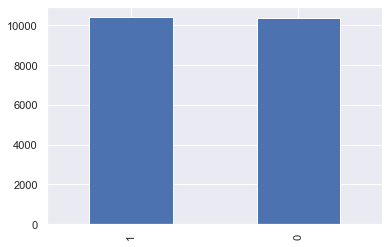

In [5]:
sns.set()
df_train.label.value_counts().plot.bar()

In [6]:
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df_test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [8]:
#Filling some values in ['author'] by droping duplicate values in ['title'] nad maping with ['title'] itself.
full_data = [df_train, df_test]
for feature in full_data:
    g = feature.dropna(subset=['author']).drop_duplicates('title').set_index('title')['author']
    feature['author'] = feature['author'].fillna(feature['title'].map(g))

    m = feature.dropna(subset=['title']).drop_duplicates('author').set_index('author')['title']
    feature['title'] = feature['title'].fillna(feature['author'].map(m))

In [9]:
df_train.isnull().sum()

id           0
title      486
author    1905
text        39
label        0
dtype: int64

In [10]:
df_test.isnull().sum()

id          0
title     105
author    497
text        7
dtype: int64

In [11]:
df_train=df_train.dropna()
df_test=df_test.dropna()

df_train=df_train.reset_index()
df_test=df_test.reset_index()

print(df_train.shape)
print(df_test.shape)

df_train.head()

(18409, 6)
(4598, 5)


,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [12]:
len(df_train['title'])

18409

In [13]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

Ps = PorterStemmer()
corpus_train = []
for i in range(0, len(df_train['title'])):
    review = re.sub('[^a-zA-Z]', ' ', df_train['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [Ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_train.append(review)
    
corpus_test = []
for i in range(0, len(df_test['title'])):
    review = re.sub('[^a-zA-Z]', ' ', df_test['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [Ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus_train).toarray()

final_test= cv.fit_transform(corpus_test).toarray()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X_tfid=tfidf_v.fit_transform(corpus_train).toarray()

In [16]:
X.shape ,final_test.shape, X_tfid.shape

((18409, 5000), (4598, 5000), (18409, 5000))

In [17]:
y=df_train['label']

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Train accuracy:   0.977
Test accuracy:   0.934
Confusion matrix, without normalization


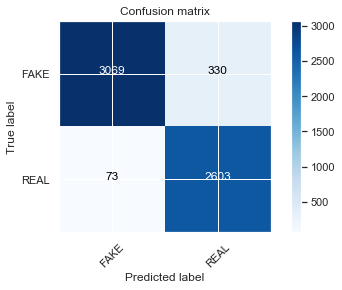

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
logit=LogisticRegression()

logit.fit(X_train, y_train)
pred = logit.predict(X_test)
score = accuracy_score(y_test, pred)
score_2=logit.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [22]:
#Plotting Roc_Auc Curve

def plot_roc_curve(y_train_actual,train_pred_prob,y_test_actual,test_pred_prob,*args):
    AUC_train=roc_auc_score(y_train_actual,train_pred_prob)
    AUC_test=roc_auc_score(y_test_actual,test_pred_prob)
    
    if len(args)==0:
        print("AUC_Train : ",AUC_train)
        print("AUC_Test : ",AUC_test)
        fpr,tpr,threshold=roc_curve(y_train_actual,train_pred_prob)
        fpr_tst,tpr_tst,threshold=roc_curve(y_test_actual,test_pred_prob)
        roc_plot(fpr, tpr, fpr_tst, tpr_tst)
        
    else:
        AUC_Valid = roc_auc_score(args[0], args[1])
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        print("Validation AUC = ", AUC_Valid)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        fpr_val, tpr_val, thresholds = roc_curve(args[0], args[1])
        roc_plot(fpr, tpr, fpr_tst, tpr_tst, fpr_val, tpr_val)

In [23]:
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, *args):


    fig = plt.plot(fpr, tpr, label='Train')
    fig = plt.plot(fpr_tst, tpr_tst, label='Test')

    if len(args) == 0:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        fig = plt.plot(args[0], args[1], label='Validation')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

AUC_Train :  0.9982003143113034
AUC_Test :  0.9794772796536044


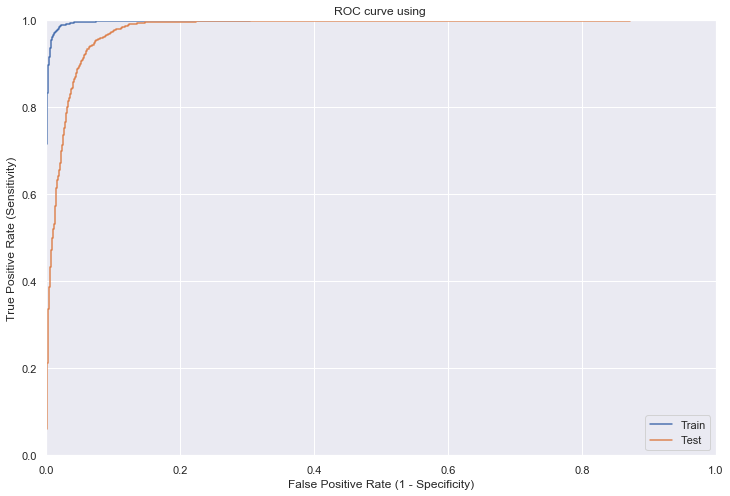

In [24]:
from sklearn.metrics import roc_curve,roc_auc_score
plt.subplots(figsize=(12, 8))
train_prob = logit.predict_proba(X_train)[:, 1]
test_prob = logit.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, train_prob,
               y_test, test_prob)

#### Changing threshold for logit to compute accuracy at each value

In [25]:
pred_proba_df = pd.DataFrame(logit.predict_proba(X_test)[:,1])

threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8]
for i in threshold_list:
    print ('For i = {} '.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)    
    test_accuracy = accuracy_score(y_test,Y_test_pred)
    print('Accuracy {}'.format(test_accuracy))

    print(confusion_matrix(y_test,Y_test_pred))

For i = 0.05 
Accuracy 0.9048559670781893
[[2830  569]
 [   9 2667]]
For i = 0.1 
Accuracy 0.9109465020576132
[[2868  531]
 [  10 2666]]
For i = 0.15 
Accuracy 0.9147325102880658
[[2894  505]
 [  13 2663]]
For i = 0.2 
Accuracy 0.9186831275720164
[[2921  478]
 [  16 2660]]
For i = 0.25 
Accuracy 0.9216460905349795
[[2944  455]
 [  21 2655]]
For i = 0.3 
Accuracy 0.9247736625514403
[[2967  432]
 [  25 2651]]
For i = 0.35 
Accuracy 0.9275720164609054
[[2997  402]
 [  38 2638]]
For i = 0.4 
Accuracy 0.9292181069958848
[[3019  380]
 [  50 2626]]
For i = 0.45 
Accuracy 0.9325102880658436
[[3045  354]
 [  56 2620]]
For i = 0.5 
Accuracy 0.9336625514403292
[[3069  330]
 [  73 2603]]
For i = 0.55 
Accuracy 0.9351440329218107
[[3100  299]
 [  95 2581]]
For i = 0.6 
Accuracy 0.936954732510288
[[3129  270]
 [ 113 2563]]
For i = 0.65 
Accuracy 0.9367901234567901
[[3156  243]
 [ 141 2535]]
For i = 0.7 
Accuracy 0.9358024691358025
[[3192  207]
 [ 183 2493]]
For i = 0.75 
Accuracy 0.9290534979423868


In [26]:
from sklearn.tree import DecisionTreeClassifier

dtc_=DecisionTreeClassifier()

dtc_.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Train accuracy:   1.000
Test accuracy:   0.913
Confusion matrix, without normalization


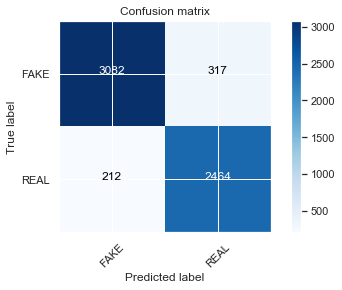

In [27]:
pred = dtc_.predict(X_test)

score = accuracy_score(y_test, pred)
score_2=dtc_.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf_=RandomForestClassifier()

clf_.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train accuracy:   1.000
Test accuracy:   0.933
Confusion matrix, without normalization


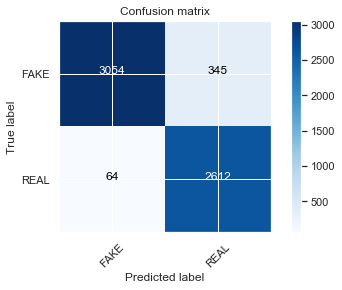

In [29]:
pred = clf_.predict(X_test)
score = accuracy_score(y_test, pred)
score_2=clf_.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Train accuracy:   0.922
Test accuracy:   0.917
Confusion matrix, without normalization


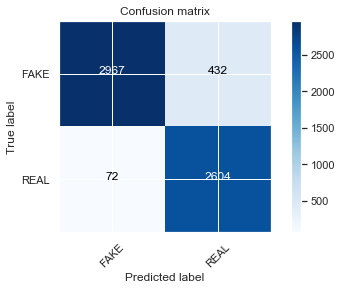

In [30]:
from sklearn.ensemble import AdaBoostClassifier
adb_clf=AdaBoostClassifier()

adb_clf.fit(X_train, y_train)
pred = adb_clf.predict(X_test)
score = accuracy_score(y_test, pred)
score_2=adb_clf.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Train accuracy:   0.909
Test accuracy:   0.933
Confusion matrix, without normalization


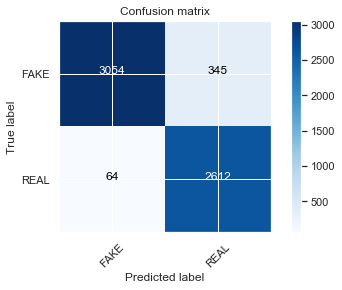

In [31]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_jobs=-1)

xgb_clf.fit(X_train, y_train)
pred = clf_.predict(X_test)
score = accuracy_score(y_test, pred)
score_2=xgb_clf.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### Using TF-IDF_Vectorizer

Train accuracy:   1.000
Test accuracy:   0.935
Confusion matrix, without normalization


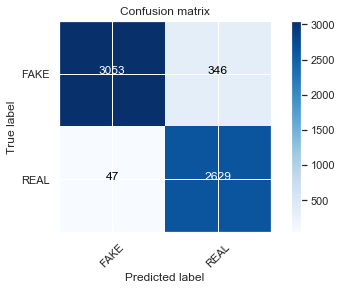

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y, test_size=0.33, random_state=0)

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

clf_=RandomForestClassifier()

clf_.fit(X_train, y_train)
pred = clf_.predict(X_test)
score = accuracy_score(y_test, pred)
score_2=clf_.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### Since we are getting similar accuracy in both Count_Vectorizer and TF-IDF_Vectorizer

Train accuracy:   0.894
Test accuracy:   0.964
Confusion matrix, without normalization


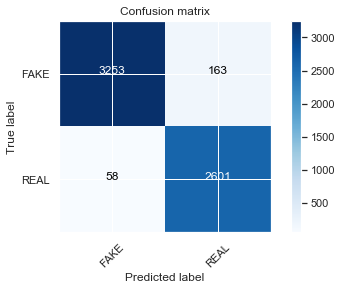

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

rfc=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rfc.fit(X_train, y_train)
pred = clf_.predict(X_test)
score = accuracy_score(y_test, pred)
score_2=rfc.score(X_train, y_train)
print("Train accuracy:   %0.3f" % score_2)
print("Test accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [35]:
test_pred = clf_.predict(final_test)